In [103]:
# Se importan las librerías necesarias 

import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import numpy as np
from PIL import Image
import cv2
import os
from skimage.io import imread
import skimage.filters as filters
import skimage.morphology as morph
import os
from os import listdir
from plantcv import plantcv as pcv

# Función  para gráficar una imagen 
def plot(imagen,color='black',title=None,cmapa='gray',pic = False,subplot  = (1,1,1),vmin = 0, vmax = 255):
    if pic == True:
        plt.figure(figsize=(15,8))
    plt.subplot(subplot[0],subplot[1],subplot[2])
    plt.axis('off')
    plt.imshow(imagen,cmap = cmapa,vmin = vmin, vmax = vmax)
    plt.title(title,color = color)
# Función para cargar una imagen en escala de grises
def load_gray_image(image_path):
    
    coloured_image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(coloured_image, cv2.COLOR_BGR2GRAY)
    return gray_image

# Función para crear histogramas
def plot_img_hist (image,title,subrows,subcols,num,size1,size2):
    fig = plt.figure(figsize=(size1,size2))
    plt.subplot(subrows,subcols,num)
    plt.imshow(image,cmap='gray');plt.title(title)
    color = ('r','g','b')
    plt.subplot(subrows,subcols,num+1)
    plt.title(" Histograma " + title)

    if len(image.shape) > 2 :            
        for i,col in enumerate(color):
            histr = cv2.calcHist([image],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
    else:
        hist,bins = np.histogram(image.ravel(),256,[0,256])
        plt.plot(hist, color='gray' )
        plt.xlim([0,256])

# Función para binarizar una imagen
def threshold(img,tipo,t):
    _ , image = cv2.threshold(img,t,255,tipo)
    lista = {0:'THRESH_BINARY',
             1:'THRESH_BINARY_INV',
             2:'THRESH_TRUNC',
             3:'THRESH_TOZERO',
             4:'THRESH_TOZERO_INV',
             8:'THRESH_OTSU',
             16:'THRESH_TRIANGLE',
             7:'THRESH_MASK'    }
    plot(image, pic = True,subplot = (1,2,2),title = 'Imagen binarizada con tipo de umbralización {}.'.format(lista[tipo]))
    plot(img,subplot = (1,2,1), title= f'Imagen filtrada')
    return _

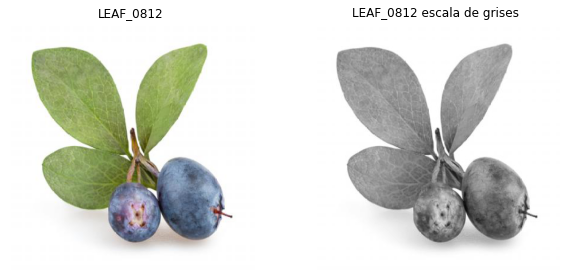

In [104]:
## Comprobamos las funciones de importacion y gráficar
imagen = '0812'
carpeta = 'DataSet'
img_test = cv2.cvtColor(cv2.imread(f'{carpeta}/train/LEAF_{imagen}.jpg'), cv2.COLOR_BGR2RGB)
img_gray = load_gray_image(f'{carpeta}/train/LEAF_{imagen}.jpg')
plt.figure(figsize=(10,10))
plot(img_test,subplot=(2,2,1) ,title=f'LEAF_{imagen}')
plot(img_gray,subplot=(2,2,2) ,title=f'LEAF_{imagen} escala de grises')

In [105]:
## Definimos los vectores para el espacio de color
# Rojo
abc_r = (1,0,0)
# Verde
abc_g = (0,1,0)
# Azul
abc_b = (0,0,1)

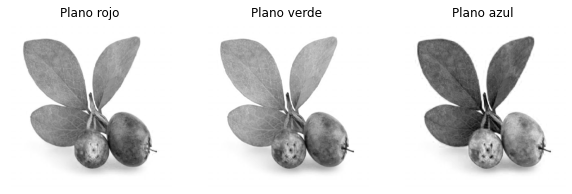

In [106]:
## Se separan las imagenes en cada canal del espacio de color 
imagen_r = np.dot(img_test,abc_r)
imagen_g = np.dot(img_test,abc_g)
imagen_b = np.dot(img_test,abc_b)

plt.figure(figsize=(10,10))

plot(imagen_r,subplot=(1,3,1),title="Plano rojo")

plot(imagen_g, subplot=(1,3,2),title="Plano verde")

plot(imagen_b, subplot=(1,3,3) , title="Plano azul")

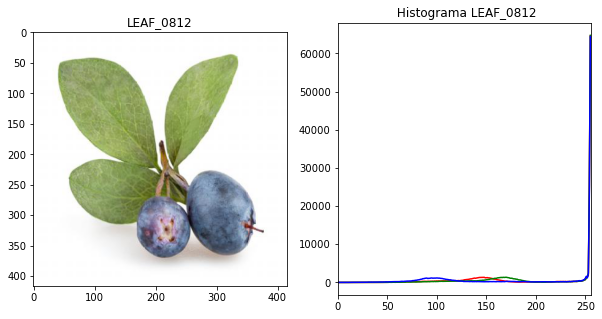

In [107]:
## Gráficamos los histogramas de color para una imagen de prueba
plot_img_hist(img_test,f'LEAF_{imagen}',1,2,1,10,5)

In [108]:
# En el segundo argumento de la función, el número indica el canal
hist_r = cv2.calcHist([img_test],[2],None,[256],[0,256])
dato = 0
count = 0
posicion = 0
for i in hist_r[0:230]:
    if i > dato:
        dato = i
        posicion = count
    i += 1
    count += 1
print(posicion, dato[0])

100 1172.0


In [109]:
median_value = np.percentile(hist_r[0:229], 75) 
print(median_value)

319.0


In [110]:
dato = 0
count = 0
posicion = 0
for i in hist_r[0:230]:
    if i == median_value:
        dato = i
        posicion = count
    i += 1
    count += 1
print(posicion, dato[0])

68 320.0


In [111]:
def mask_edge(img):
    
    #deteccion d bordes
    #edges = pcv.canny_edge_detect(img)
    edges2 = pcv.canny_edge_detect(img=img, high_thresh=60, low_thresh =40, sigma=1)
    
    #cierre de bordes
    radius = 2
    selem = morph.disk(radius)
    cierre = morph.binary_closing(edges2,selem)
    
    #dilatacion
    elem1 = morph.rectangle(3,3)
    elem2 = morph.disk(3)
    
    dilatacionx1 = morph.binary_dilation(cierre,elem1)
    dilatacionx2 = morph.binary_dilation(dilatacionx1,elem1)
    dilatacionx3 = morph.binary_dilation(dilatacionx2,elem1)
    dilatacionx4 = morph.binary_dilation(dilatacionx3,elem1)
    dilatacionx5 = morph.binary_dilation(dilatacionx4,elem1)
    dilatacionx6 = morph.binary_dilation(dilatacionx5,elem1)
    dilatacionx7 = morph.binary_dilation(dilatacionx6,elem1)
    dilatacionx8 = morph.binary_dilation(dilatacionx7,elem1)
    dilatacionx9 = morph.binary_dilation(dilatacionx8,elem1)
    
    #cierre = cierre > 128
    filled = morph.remove_small_holes(dilatacionx3,area_threshold=3000) #min_size es el area en pixeles de los huecos a rellenar
    #fig, ax2 = plt.subplots()
    # plt.imshow(filled, cmap='gray')

    return filled

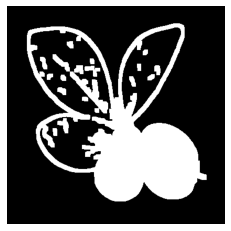

In [112]:
filled = mask_edge(img_test)
plot(filled*255)

In [113]:
#Función para binarizar con condiciones en cada canal 
def binaryChannels(image, umbralR, umbralG, umbralB, mayorR = False, mayorG = False, mayorB = False):
     binary = np.zeros((len(image), len(image[0])))

     imagen_r = np.dot(image,abc_r)
     imagen_g = np.dot(image,abc_g)
     imagen_b = np.dot(image,abc_b)

     for i in range(len(image)):
          for j in range(len(image[0])):
               conditionR = imagen_r[i,j] <= umbralR
               conditionG = imagen_g[i,j] <= umbralG
               conditionB = imagen_b[i,j] <= umbralB
               if(mayorR):
                    conditionR = not conditionR
               if(mayorG):
                    conditionG = not conditionG
               if(mayorB):
                    conditionB = not conditionB

               if(conditionR and conditionG and conditionB):
                    binary[i,j] = 0

               else:
                    binary[i,j] = 255

     return binary
     
#Función para eliminar los colores con tendencia al negro
def removeLesses(imagen, lessNumber):
     imagen_r = np.dot(imagen,abc_r)
     imagen_g = np.dot(imagen,abc_g)
     imagen_b = np.dot(imagen,abc_b)

     aux = np.empty_like(imagen) 
  
     aux[:] = imagen

     for i in range(len(imagen)):
          for j in range(len(imagen[0])):
               if((imagen_r[i,j] <= lessNumber) and (imagen_g[i,j] <= lessNumber) and (imagen_b[i,j] <= lessNumber) ):
                    aux[i,j,0] = 255
                    aux[i,j,1] = 255
                    aux[i,j,2] = 255
     return aux

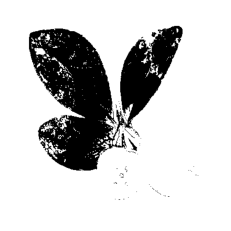

In [114]:
def mask_binary(img):
    binary = img.copy()
    binary = removeLesses(binary,110)
    binary = binaryChannels(binary, 179, 105, 113, mayorG= True)
    return binary

binarizada = mask_binary(img_test)
plot(binarizada)

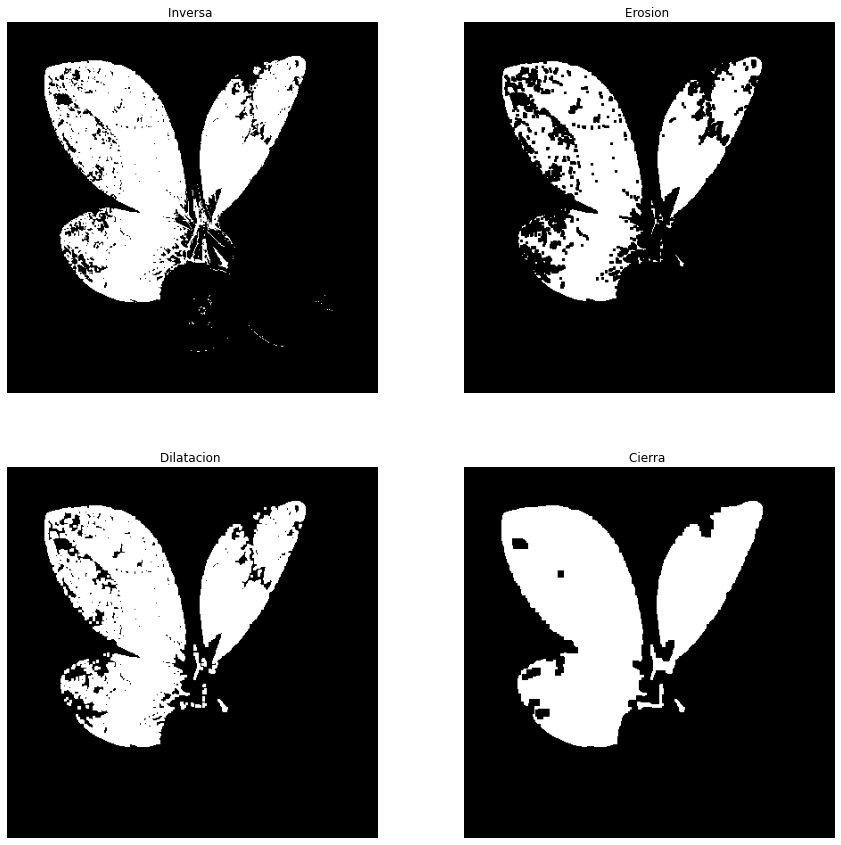

In [115]:
kernel = np.ones((3,3),np.uint8)
kernel2 = np.ones((7,7),np.uint8)
ret,thresh1 = cv2.threshold(binarizada,150,255,cv2.THRESH_BINARY_INV)
morph_erosion = cv2.erode(thresh1,kernel,iterations = 1)
# morph_erosion2 = cv2.erode(morph_erosion,kernel2,iterations = 1)
morph_dilation = cv2.dilate(morph_erosion,kernel,iterations = 1)
morph_closing = cv2.morphologyEx(morph_dilation, cv2.MORPH_CLOSE, kernel2)
plt.figure(figsize=(15,15))
plot(thresh1,subplot = (2,2,1), title= 'Inversa ')
plot(morph_erosion,subplot = (2,2,2), title= 'Erosion ')
plot(morph_dilation,subplot = (2,2,3), title= 'Dilatacion ')
plot(morph_closing,subplot = (2,2,4), title= 'Cierra ')

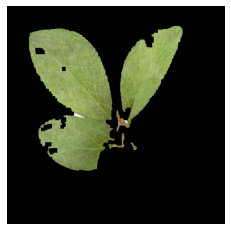

In [116]:
R = imagen_r*(morph_closing/255)
G = imagen_g*(morph_closing/255)
B = imagen_b*(morph_closing/255)

final = np.zeros((len(R),len(R[0]),3), 'uint8')
final[..., 0] = R
final[..., 1] = G
final[..., 2] = B
plot(final)